<div class="title">Practical Assignment: Support Vector Machines</div>
<div class="subtitle">Métodos Avanzados en Aprendizaje Automático</div>
<div class="author">Carlos María Alaíz Gudín - Universidad Autónoma de Madrid</div>

---

### Enrique Ernesto De Alvear Doñate y Javier Alarcón Caracena

**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [1]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

This cell imports the packages to be used (all of them quite standard except for `utils`, which is provided with the notebook).

In [3]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from utils import plot_dataset_clas, plot_svc

matplotlib.rc('figure', figsize=(15, 5))
seed = 123

# Introduction

This practical assignment consists in implementing a simplified version of the SVC class of `scikit-learn`.

This class will contain two fundamentals routines, one for training a non-linear SVC (using the RBF kernel), based on the SMO algorithm for solving the dual optimization problem, and the other one for predicting over new out-of-sample points.

# SMO Algorithm

## Optimization Problem

The dual optimization problem for the Soft-Margin SVM is:
$$
 \left \{ \begin{array}{l} \min_{\boldsymbol{\alpha} \in \mathbb{R}^N} \frac{1}{2} \boldsymbol{\alpha}^\intercal \tilde{\mathbf{K}} \boldsymbol{\alpha} - \boldsymbol{\alpha}^\intercal \mathbf{1} \\ \text{ s.t. } \boldsymbol{\alpha}^\intercal \mathbf{y} = 0 , 0 \le \boldsymbol{\alpha} \le C ,
 \end{array} \right .
$$
where $\tilde{k}_{ij} = y_i y_j \mathcal{K}(\mathbf{x}_i, \mathbf{x}_j)$.

This optimization problem is a QP problem, which is usually solved using an *ad hoc* algorithm: Sequential Minimal Optimization (SMO).

## SMO and Coordinate Descent

The main idea behind SMO is that the optimization problem is too involved to be solved as a whole, but it can be largely simplified considering only a few variables at a time.
In this divide-and-conquer approach, called coordinate descent, the objective function is iteratively minimized over the different variables.

In particular, SMO deals with two variables, the smaller working group that can be modified while respecting the constraints.
Formally, the algorithm updates the current $\alpha^\text{old}_i$ and $\alpha^\text{old}_j$ coefficients to some new values $\alpha_i$ and $\alpha_j$, assuming that $\boldsymbol{\alpha}^\text{old}$ satisfies $(\boldsymbol{\alpha}^\text{old})^\intercal \mathbf{y} = 0$. In order to keep respecting the constraint in the new estimation, the following equation needs to be fulfilled:
\begin{align*}
 & y_i \alpha^\text{old}_i + y_j \alpha^\text{old}_j = y_i \alpha_i + y_j \alpha_j \\
 &\implies y_i (\alpha_i - \alpha^\text{old}_i) = - y_j (\alpha_j - \alpha^\text{old}_j) \\
 &\implies \alpha_i = \alpha^\text{old}_i - y_i y_j (\alpha_j - \alpha^\text{old}_j) .
\end{align*}

For simplicity, one can assume that the update for the $j$-th coefficient is given by $\alpha_j = \alpha^\text{old}_j + d$, and hence the optimization problem becomes a simple one-dimensional minimization.
Therefore, it can be solved by computing the derivative with respect to $d$ and equating to $0$.
After some derivations, the optimum unconstrained update turns out to be:
\begin{align*}
 d &= \frac{y_j (E(\mathbf{x}_j, y_j) - E(\mathbf{x}_i, y_i))}{\kappa} , \text{ where} \\
 \kappa &= 2 \mathcal{K}(\mathbf{x}_i, \mathbf{x}_j) - \mathcal{K}(\mathbf{x}_i, \mathbf{x}_i) - \mathcal{K}(\mathbf{x}_j, \mathbf{x}_j) , \text{ and} \\
 E(\mathbf{x}, y) &= \sum_{i = 1}^N \alpha^\text{old}_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) - y .
\end{align*}

## Clipping

The previous update does not take into account the box constrains $0 \le \alpha_i, \alpha_j \le C$.
In order to satisfy these constraints for both $\alpha_i$ and $\alpha_j$, $\alpha_j$ has to be clipped to the interval $[L, H]$, where
$$
 \begin{cases}
  L = \max(0, \alpha^\text{old}_j - \alpha^\text{old}_i), & H = \min(C, C - \alpha^\text{old}_i + \alpha^\text{old}_j) & \text{if } y_i \neq y_j , \\
  L = \max(0, \alpha^\text{old}_j + \alpha^\text{old}_i - C), & H = \min(C, \alpha^\text{old}_i + \alpha^\text{old}_j) & \text{if } y_i = y_j .
 \end{cases}
$$

Therefore, the update for $\alpha_j$ becomes:
$$ \alpha_j = \min(\max(\alpha^\text{old}_j + d, L), H) , $$
and, as mentioned above, the corresponding update for $\alpha_i$ is:
$$ \alpha_i = \alpha^\text{old}_i - y_i y_j (\alpha_j - \alpha^\text{old}_j) . $$

## Selecting the Working Pair

There are different methods for selecting the working pair of coefficients $(i, j)$ that will be updated.
Usually, first or second order information is used to choose the working set, trying to find those that will provide the largest minimization of the objective function.

Nevertheless, in this work a simplified version of SMO will be implemented.
The first coefficient $i$ will be selected just iteratively, cycling over all the possible values $i = 1, 2, \dotsc, N$. The second coefficient $j$ is selected randomly over the remaining possible values $j \neq i$.

It should be noted that this approach will not guarantee the convergence in general, since not all possible pairs $(i, j)$ are explored, but it will work in most problems.

## Stopping Criteria

The algorithm will be terminated when a certain maximum number of iterations is reached (for each iteration, all the coefficients are updated), or when after one iteration the total change of the coefficients is smaller than a certain tolerance, $\| \boldsymbol{\alpha} - \boldsymbol{\alpha}^\text{old}\| < \epsilon$.

Since the working pair is generated randomly, it can happen that after a whole iteration the changes are smaller than $\epsilon$ not because the optimization is finished, but because of "bad luck". A workaround is to set $\epsilon = 0$ to force all the iterations.

## Computing the Intercept

Once the optimum dual coefficients $\boldsymbol{\alpha}^*$ have been estimated, the intercept $b^*$ can be computed knowing that any support vector $\mathbf{x}_k$ with $0 < \alpha^*_k < C$ satisfies:
$$ b^* = y_k - \sum_{i = 1}^N \alpha^*_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}_k) . $$

This equality is usually averaged over all the possible vectors $k$ satisfying $0 < \alpha^*_k < C$ for reasons of numerical stability.

## Prediction

Once the model is trained and the optimal parameters $\boldsymbol{\alpha}^*$ and $b^*$ are known, the score predicted over a new sample $\mathbf{x}$ is:
$$ f(\mathbf{x}) = \sum_{i = 1}^N \alpha^*_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) + b . $$

Finally, the class is assigned with:
$$ \hat{y} = \operatorname{sign}(f(\mathbf{x})) . $$

# Implementation of the SVC

## Requirements

The objective of this assignment is to complete the class `MySVC` sketched below, which should contain at least the following methods.

---
```python
__init__(self, C=1.0, gamma="scale", tol=0.0001, max_iter=10000)
```
* This is the construction method for the class, with the following parameters:
    * `C`: Regularization parameter $C$ of the SVC.
    * `gamma`: Kernel parameter $\gamma$ of the RBF kernel.
    * `tol`: Tolerance for the stopping criterion $\epsilon$.
    * `max_iter`: Maximum number of iterations (in the sense of epochs, each iteration contains a pass through all the coefficients).
* This method should only store the parameters in fields of the class, to be used when needed.

---
```python
fit(self, X, y)
```
* This is the training method, with the following parameters:
    * `X`: Training data matrix $\mathbf{X} \in \mathbb{R}^{N \times d}$.
    * `y`: Vector of labels $\mathbf{y}$, with $y_i \in \{-1, +1\}$.
* This method should solve the dual optimization problem, storing the obtained coefficients and other useful information in fields of the class.

---
```python
decision_function(self, X)
```
* This is the method that computes the output of the SVC, with the following parameters:
    * `X`: Test data matrix $\mathbf{X}' \in \mathbb{R}^{N' \times d}$.
* This method should predict the output (the score) of the SVC, using the information stored in the fields of the class, and return it as a vector

---
```python
predict(self, X)
```
* This is the method that computes the predicted class of the SVC, with the following parameters:
    * `X`: Test data matrix $\mathbf{X}' \in \mathbb{R}^{N' \times d}$.
* This method should predict the assigned class of the SVC, using the information stored in the fields of the class, and return it as a vector.

## Recommendations

Additional auxiliary methods can be defined to simplify the code.
Some suggestions are:

1. A method to compute the output of the SVC, with the current estimated parameters but without considering the intercept:
$$ \sum_{i = 1}^N \alpha_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) . $$
1. A method to compute $E(\mathbf{x}, y)$.
1. A method to compute the lower and upper bounds $L$ and $H$ for the clipping of the update.
1. A method to estimate $b^*$.

## Implementation

<div class="qst">

* Complete the `MySVC` class below, satisfying the described requirements.

</div>

In [4]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel

class MySVC():
    """
        SVC with a simplified version of SMO.
    """
    def __init__(self, C=1.0, gamma="scale", tol=0.001, max_iter=100):
        # Assignment of the hyper-parameters (complete).
        self.C = C
        self.gamma=gamma
        self.tol=tol
        self.max_iter=max_iter

    def fit(self, X, y):
        # Constants.
        n_pat = X.shape[0]
        n_dim = X.shape[1]

        # Options for gamma (for compatibility with sklean).
        if (self.gamma == "scale"):
            self.gamma = 1.0 / (n_dim * X.var())
        if (self.gamma == "auto"):
            self.gamma = 1.0 / n_dim

        # Initialization of the dual coefficients (named "a" instead of "alpha" for simplicity).
        self.a = np.zeros(n_pat)

        # Other initializations (complete).
        self.kernel=lambda X,Y: rbf_kernel(X,Y,gamma=self.gamma)
        K = self.kernel(X,None)

        # Loop over the iterations.
        for it in range(self.max_iter):
            # Initializations (complete).
            d = 0.0
            L = 0.0
            H = 0.0

            # Loop over the coefficients.
            for i in range(0, n_pat):
                j = self.choose_j(i)

                #Calcular la d
                a_new = self.a.copy()
                k= 2* K[i,j] - K[i,i] - K[j,j]
                d=y[j] * (self.calcular_E(y=y,K=K[:,j],y_j=y[j]) - self.calcular_E(y=y,K=K[:,i],y_j=y[i])) / k

                #Calcular L, H
                L,H = self.calcular_LH(y=y,i=i,j=j)
                
                #Actualizamos a_j, a_i
                a_new[j] = min(max(a_new[j]+d,L),H)
                a_new[i] = self.a[i] - y[i]*y[j]*(a_new[j]-self.a[j])
                a_old=self.a.copy()
                self.a=a_new

                #Actualizamos los valores y guardamos los anteriores
                
                ##Comprobamos el criterio de parada
            if np.linalg.norm(a_old - self.a)<self.tol:
                    print(f'Hemos alcanzado el criterio de parada con {it+1} iteraciones')
                    break


        # Storage of the obtained parameters and computation of the intercept (complete).
        self.support_ =  np.nonzero(self.a)[0] # Guardamos las posiciones de los coeficientes no nulos
        self.dual_coef_ = self.a[self.support_] * y[self.support_] #Coeficientes no nulos y_i*a_i
        self.support_vectors_ = X[self.support_,:] #Vectores asociados a los coeficientes no nulos
        self.b = self.estimar_b(y[self.support_]) #Calculamos b 
        self.n_support_ = np.array([np.sum(y[self.support_]==-1), np.sum(y[self.support_]==1)]) #Cantidad de vectores soporte de cada clase
        return self

    def decision_function(self, X):
        
        return self.outputSVC(X) + self.b

    def predict(self, X):
        return np.sign(self.decision_function(X))

    # Auxiliary methods.
    def choose_j(self, i):
        v = np.arange(len(self.a))
        return np.random.choice(v[v != i])
    
    def calcular_E(self, y_j,y, K):
        return ((self.a * y) @ K ) - y_j
    
    def calcular_LH(self, y, i, j, ):
        if y[i] != y[j]:
            L=max(0, self.a[j] - self.a[i])
            H=min(self.C, self.C - self.a[i] + self.a[j])
            return L,H
        else:
            L=max(0, self.a[j] + self.a[i] - self.C)
            H=min(self.C, self.a[i] + self.a[j])
            return L,H
    
    def estimar_b(self, y_support):
        indices = np.where(self.a[self.support_]<self.C)[0]
        return np.mean(y_support[indices] - self.outputSVC(self.support_vectors_[indices,:]))

    def outputSVC(self, X):
        return self.dual_coef_ @ self.kernel(self.support_vectors_, X)


# Experiments with the SVC

## Comparative with `scikit-learn`

The following cell generates the *moons* dataset, dividing it into train and test splits, and depicting it.

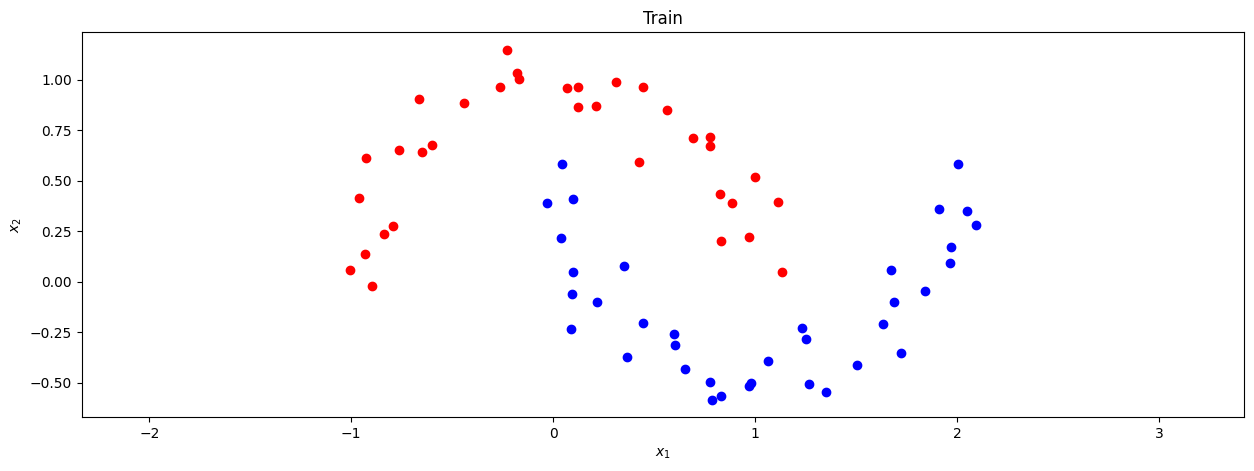

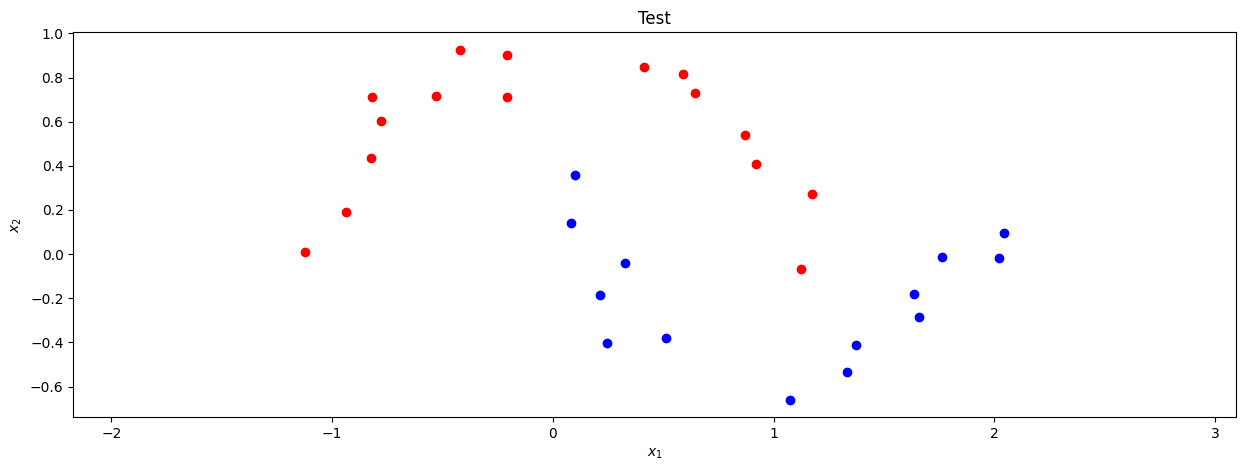

In [5]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

x, y = make_moons(noise=1e-1, random_state=seed)
y[y != 1] = -1

x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.3, random_state=seed)

plot_dataset_clas(x_tr, y_tr)
plt.title('Train'); plt.show()
plot_dataset_clas(x_te, y_te)
plt.title('Test'); plt.show()

<div class="qst">

* Train an SVC model over the training data (`x_tr`, `y_tr`), using both the `SVC` class of `scikit-learn` and the implemented `MySVC` class.
* Predict using the previous two models over the test data (`x_te`, `y_te`).
* Compare that both classes provide the same outputs (in terms of the decision function and of the predicted class), describing the obtained results.
  If needed, reduce the default stopping tolerance and/or increase the default maximum number of iterations.

</div>

In [17]:
C = 1
gamma = 'scale'

model_my = MySVC(C=C, gamma=gamma)
model_sk = SVC(C=C, gamma=gamma)

# Training of the models.
model_my.fit(x_tr, y_tr)
model_sk.fit(x_tr, y_tr)

# Comparative of the predicted scores.
prediccion_my = model_my.predict(x_te)
prediccion_sk = model_sk.predict(x_te)

#Decision function
function_my = model_my.decision_function(x_te)
function_sk = model_sk.decision_function(x_te)

# Comparative of the predicted classes (complete).
print(f'Nuestra predicción es la siguiente:\n {prediccion_my}\n')
print(f'La prediccion de sklearn es la siguiente:\n {prediccion_sk}\n')
print(f'La diferencia entre las predicciones es:\n {abs(prediccion_my-prediccion_sk)}\n')

print(f'Nuestros outputs en la función de decesión son:\n {function_my[0:10]}\n')
print(f'Los output de la función de decisión de sklearn son:\n {function_sk[0:10]}\n')
print(f'La diferencia entre los outputs es:\n {abs(function_my-function_sk)[0:10]}\n')


Hemos alcanzado el criterio de parada con 1 iteraciones
Nuestra predicción es la siguiente:
 [ 1. -1. -1. -1. -1. -1.  1. -1.  1.  1. -1. -1.  1. -1. -1. -1.  1.  1.
 -1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.]

La prediccion de sklearn es la siguiente:
 [ 1 -1  1  1 -1 -1  1 -1  1  1 -1 -1  1 -1 -1 -1  1  1 -1 -1  1  1  1 -1
  1 -1  1 -1 -1  1]

La diferencia entre las predicciones es:
 [0. 0. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 2. 0. 0.]

Nuestros outputs en la función de decesión son:
 [ 1.7913016  -1.50764178 -0.36526935 -0.86683917 -1.43513501 -0.70272507
  0.89041096 -1.52730085  1.03943145  0.88494269]

Los output de la función de decisión de sklearn son:
 [ 1.24730358 -1.19497451  0.83685633  0.32730964 -1.41110229 -1.05405908
  0.32800281 -1.23320741  1.21372957  1.3333475 ]

La diferencia entre los outputs es:
 [0.54399801 0.31266727 1.20212567 1.19414881 0.02403272 0.35133401
 0.56240815 0.29409344 0.17429813 0.4484048 ]



Podemos ver nuestro modelo ofrece predicciones distintas al modelo de sklearn.

Prediccion de nuestro modelo:


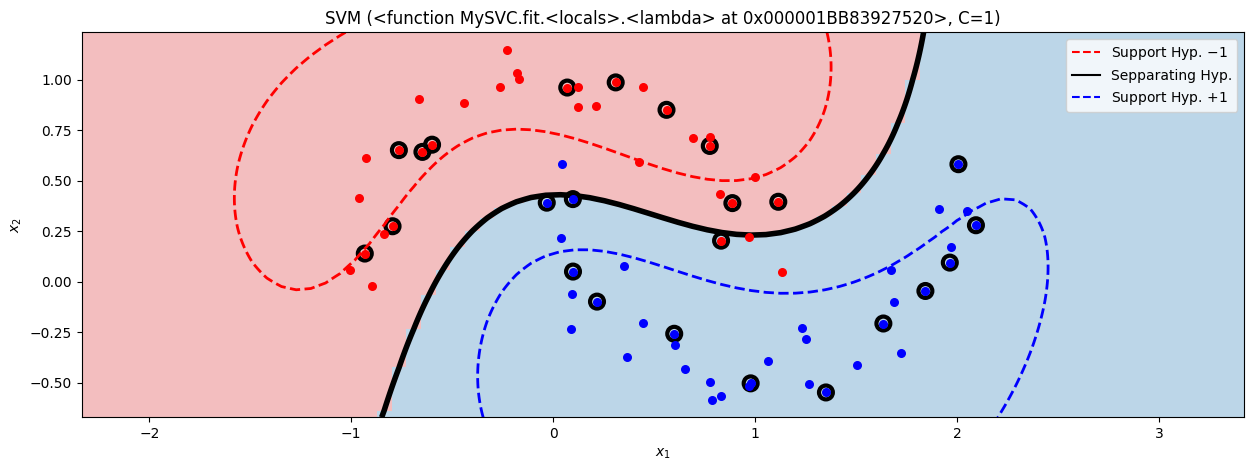

In [7]:
print("Prediccion de nuestro modelo:")
plot_svc(x_tr,y_tr, model_my)

Prediccion del modelo de sklearn:


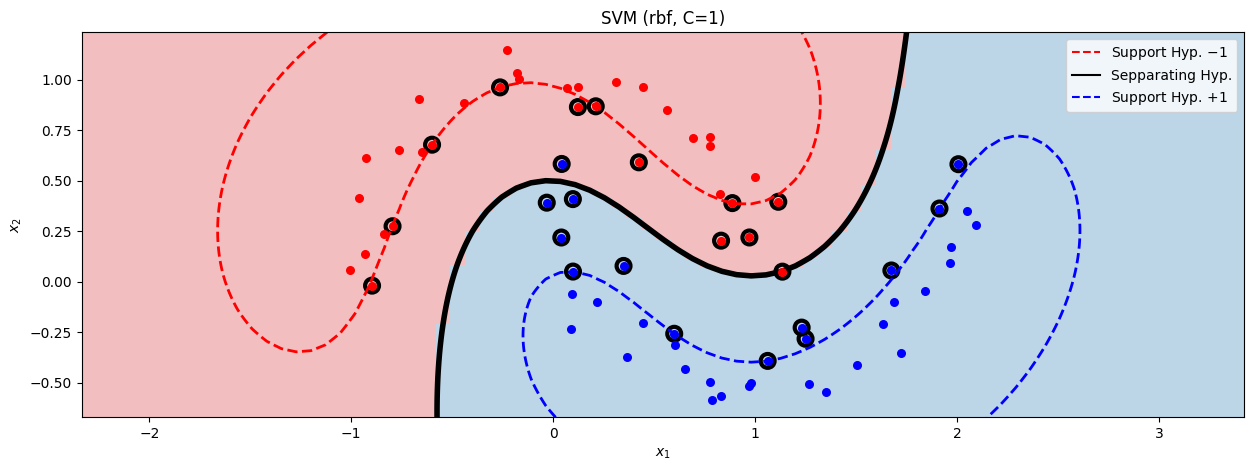

In [8]:
print("Prediccion del modelo de sklearn:")
plot_svc(x_tr,y_tr, model_sk)

Ya hemos visto que las predicciones de ambos modelos son distintas, ya que en nuestro modelo hay puntos fuera de los hiperplanos de soporte que no son vectores soporte y viceversa, hay puntos dentro de los hiperplanos de soporte que si son vectores soporte.

Esto se puede arreglar reduciendo la tolerancia del modelo, también vamos a subir las iteraciones, para asegurarnos que converja.

In [29]:
model_my = MySVC(C=C, gamma=gamma, tol=0, max_iter=500) #reducimos la tolerancia
model_my.fit(x_tr, y_tr) #entrenamos el modelo

prediccion_my = model_my.predict(x_te)

#Decision function
function_my = model_my.decision_function(x_te)

# Comparative of the predicted classes (complete).
print(f'Nuestra predicción es la siguiente:\n {prediccion_my}\n')
print(f'La prediccion de sklearn es la siguiente:\n {prediccion_sk}\n')
print(f'La diferencia entre las predicciones es:\n {abs(prediccion_my-prediccion_sk)}\n')

print(f'Nuestros outputs en la función de decesión son:\n {function_my[0:10]}\n') #Vamos a mostrar solo los 10 primeros
print(f'Los output de la función de decisión de sklearn son:\n {function_sk[0:10]}\n')
print(f'La diferencia entre los outputs es:\n {abs(function_my-function_sk)[0:10]}\n')


Nuestra predicción es la siguiente:
 [ 1. -1.  1.  1. -1. -1.  1. -1.  1.  1. -1. -1.  1. -1. -1. -1.  1.  1.
 -1. -1.  1.  1.  1. -1.  1. -1.  1. -1. -1.  1.]

La prediccion de sklearn es la siguiente:
 [ 1 -1  1  1 -1 -1  1 -1  1  1 -1 -1  1 -1 -1 -1  1  1 -1 -1  1  1  1 -1
  1 -1  1 -1 -1  1]

La diferencia entre las predicciones es:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]

Nuestros outputs en la función de decesión son:
 [ 1.24787038 -1.19481853  0.83724228  0.32782652 -1.41106213 -1.05430357
  0.32800999 -1.23311743  1.21375339  1.33325631]

Los output de la función de decisión de sklearn son:
 [ 1.24730358 -1.19497451  0.83685633  0.32730964 -1.41110229 -1.05405908
  0.32800281 -1.23320741  1.21372957  1.3333475 ]

La diferencia entre los outputs es:
 [5.66792538e-04 1.55987616e-04 3.85959248e-04 5.16878927e-04
 4.01541563e-05 2.44490616e-04 7.18273379e-06 8.99773854e-05
 2.38126702e-05 9.11847638e-05]



Tras reducir la tolerancia, podemos apreciar que las predicciones coinciden y las funciones de decisión de ambos modelos ofrecen valores muy parecidos.

Nueva prediccion de nuestro modelo:


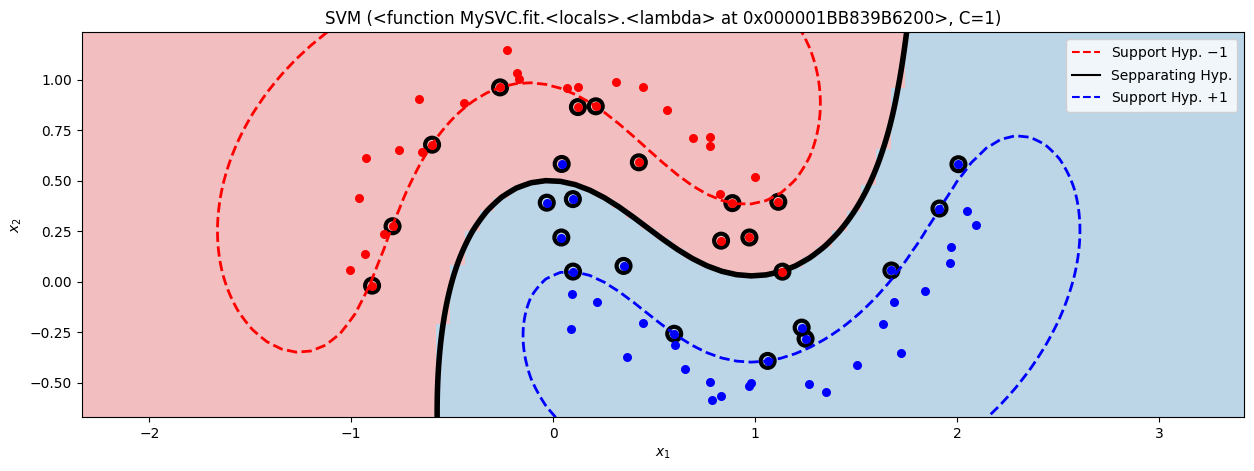

In [30]:
print("Nueva prediccion de nuestro modelo:")
plot_svc(x_tr,y_tr, model_my)

Ahora podemos apreciar que los vectores soporte son los mismos que los de sklearn y además las predicciones coinciden.

## Understanding the SVM

<div class="qst">

* Considering the model created with the `MySVC` class:
    * Extract the list of support vectors, explaining the followed approach.
    * Extract the list of training points bad and well classified, explaining the followed approach.
    * Extract the list of training points that lie over the supporting hyperplanes.
    * Extract the list of training points located on the wrong side of the supporting hyperplanes, but that are well classified.
* What are the conditions over the dual coefficients $\alpha_i$ that characterize the previous lists (if any)?

</div>

### Vectores soporte
Para obtener los vectores soporte podemos mirar los coeficientes duales y seleccionar aquellos no nulos, en nuestro caso, estos vectores los tenemos almacenados en la variable **support_vectors_**. Por otro lado, en la variable **n_support_** podemos ver la cantidad de vectores soporte de cada clase.

In [31]:
# Vectores soporte
print('Vectores soporte: \n', model_my.support_vectors_)
print('Cantidad de vectores en cada clase: \n', model_my.n_support_)


Vectores soporte: 
 [[-0.7952664   0.2746645 ]
 [ 0.59973944 -0.25787141]
 [ 0.9720389   0.21902698]
 [ 0.09841814  0.05019174]
 [ 0.42448524  0.59130712]
 [ 1.06252195 -0.39226767]
 [ 0.88775478  0.38926482]
 [ 1.23082636 -0.22735139]
 [ 1.115151    0.39583904]
 [ 0.12278879  0.8649236 ]
 [ 1.13567114  0.04975262]
 [ 1.67526518  0.05558455]
 [ 0.21104358  0.86864391]
 [-0.59960441  0.67856403]
 [-0.26285754  0.96232495]
 [ 0.0423632   0.58312272]
 [-0.03147581  0.39140976]
 [ 1.25022826 -0.2826266 ]
 [ 2.00729148  0.58188871]
 [ 0.04062784  0.21890576]
 [ 0.83174596  0.20326404]
 [ 1.91345677  0.3625312 ]
 [ 0.09781582  0.4090848 ]
 [-0.89675203 -0.01943427]
 [ 0.34875151  0.07811214]]
Cantidad de vectores en cada clase: 
 [12 13]


### Puntos de entrenamiento mal  y bien clasificados
A la hora de estudiar la clasificación de los puntos y como funciona el modelo podemos observar estas 3 situaciones:

* $\alpha_i=0$ implica que el punto $x_i$ está bien clasificado y no afecta al modelo (no es un vector soporte).
* $0<\alpha_i<C$ implica que el punto $x_i$ está sobre el hiperplano de soporte y afecta al resultado del modelo.
* $\alpha_i = C$ implica que el punto $x_i$ no está en el hiperplano de soporte, sin embargo no podemos decidir a priori si está bien clasificado.

En la variable **dual_coef_** tenemos guardado los coeficientes duales, es decir $y_i*\alpha_i$, supongamos que a la predicción del punto $x_i$ la llamamos $\tilde{y}_i$. Si el punto $x_i$ está mal clasificado, es claro que $\tilde{y}_i=-y_i$. Dado un punto $x_i$ que no esté en el hiperplano de soporte verifica la siguiente igualdad
    $$\tilde{y}_i*y_i*\alpha_i=-y_i*y_i*C=-C$$
Como consecuencia de esta igualdad, para detectar los puntos mal clasificado, solo tenemos que sacar los elementos que verifiquen $\tilde{y}*dual\_coef\_=-C$

In [32]:
pred = model_my.predict(x_tr)
#Clasificacion de los puntos
aux = pred[model_my.support_] * model_my.dual_coef_
indices = np.where(aux == - model_my.C)
aux2 = pred * y_tr * model_my.a
indices2 = np.where(aux2 != - model_my.C)

print('Puntos mal clasificados: \n', model_my.support_vectors_[indices])
print('Puntos bien clasificados: \n', x_tr[indices2])


Puntos mal clasificados: 
 [[1.13567114 0.04975262]
 [0.0423632  0.58312272]]
Puntos bien clasificados: 
 [[ 1.68792426 -0.0981035 ]
 [-0.7952664   0.2746645 ]
 [ 0.59973944 -0.25787141]
 [ 0.9720389   0.21902698]
 [ 0.65462368 -0.43432386]
 [ 1.26610851 -0.50682361]
 [ 0.09841814  0.05019174]
 [ 0.56155158  0.85122387]
 [ 0.42448524  0.59130712]
 [ 1.06252195 -0.39226767]
 [-0.66625776  0.90611844]
 [-0.1785632   1.03583077]
 [ 2.04744488  0.35091483]
 [-0.9623992   0.41442543]
 [ 0.83169282 -0.56838816]
 [ 0.82483944  0.43424825]
 [ 0.44598685 -0.20238606]
 [-0.92514894  0.61051612]
 [ 0.06999164  0.96156857]
 [ 0.88775478  0.38926482]
 [ 1.23082636 -0.22735139]
 [ 1.63556454 -0.20700992]
 [-0.1701044   1.00266984]
 [ 0.96998002 -0.5188826 ]
 [ 1.115151    0.39583904]
 [ 1.96456314  0.09457656]
 [ 0.12278879  0.8649236 ]
 [-0.22651016  1.14840109]
 [ 0.21729751 -0.09860236]
 [-0.8367634   0.23609495]
 [ 1.67526518  0.05558455]
 [ 0.09103819 -0.06146458]
 [ 0.09012959 -0.23445768]
 [ 

### Puntos sobre los hiperplanos de soporte

In [33]:
indices = np.where((model_my.a >0) & (model_my.a<model_my.C))[0]
print('Puntos dentro de los hiperplanos de soporte: \n', x_tr[indices,:])

Puntos dentro de los hiperplanos de soporte: 
 [[-0.7952664   0.2746645 ]
 [ 0.59973944 -0.25787141]
 [ 0.09841814  0.05019174]
 [ 1.06252195 -0.39226767]
 [ 0.88775478  0.38926482]
 [ 0.21104358  0.86864391]
 [-0.59960441  0.67856403]
 [-0.26285754  0.96232495]
 [ 1.91345677  0.3625312 ]]


### Puntos bien clasificados fuera de los hiperplanos de soporte
Como los puntos están fuera de los hiperplanos de soporte, verifican que $\alpha_i=C$, además, por estar bien clasificados verifican $\tilde{y}_i=y_i$. Por lo que tenemos que buscar los puntos que veriquen la ecuación:
$$\tilde{y}*dual\_coef\_=C$$

In [34]:
pred = model_my.predict(model_my.support_vectors_)
aux = pred * model_my.dual_coef_
indices = np.where(aux == model_my.C)
print('Puntos bien clasificados fuera del hiperplano: \n', model_my.support_vectors_[indices])


Puntos bien clasificados fuera del hiperplano: 
 [[ 0.9720389   0.21902698]
 [ 0.42448524  0.59130712]
 [ 1.23082636 -0.22735139]
 [ 1.115151    0.39583904]
 [ 0.12278879  0.8649236 ]
 [ 1.67526518  0.05558455]
 [-0.03147581  0.39140976]
 [ 1.25022826 -0.2826266 ]
 [ 2.00729148  0.58188871]
 [ 0.04062784  0.21890576]
 [ 0.83174596  0.20326404]
 [ 0.09781582  0.4090848 ]
 [-0.89675203 -0.01943427]
 [ 0.34875151  0.07811214]]
